In [1]:
# Importing the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, roc_auc_score
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Explore the data

In [3]:
print(f'Data shape:{df.shape}')

Data shape:(299, 13)


In [4]:
print(f'Total null values in data: {df.isnull().sum().sum()}')
print('----------------------------')
df.isnull().sum()

Total null values in data: 0
----------------------------


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [6]:
categorical = df[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']]
continuous = df[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']]

In [7]:
continuous.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


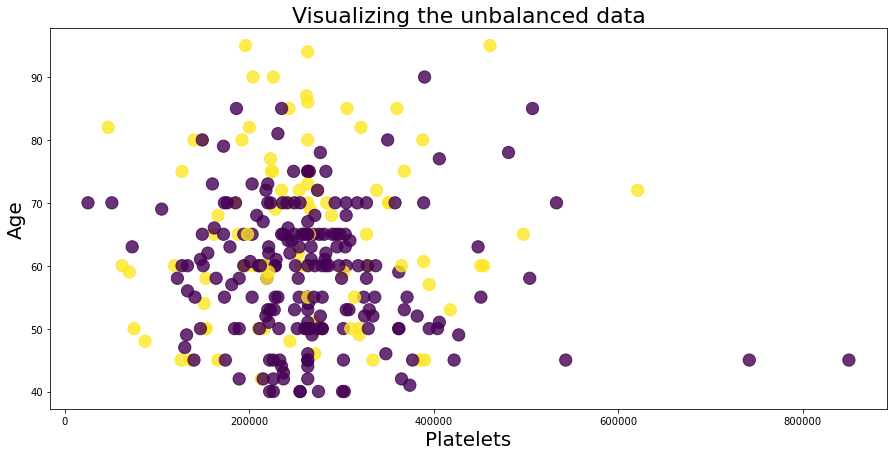

In [8]:
# scatter plot
plt.figure(figsize=(15,7))
plt.scatter(df.platelets, df.age, c = df["DEATH_EVENT"], s=150, alpha=0.8)
plt.xlabel("Platelets", fontsize=20)
plt.ylabel("Age", fontsize=20)
plt.title("Visualizing the unbalanced data", fontsize=22)

plt.savefig('../Heart Failure Prediction/images/unbalanced data.png')
plt.show()

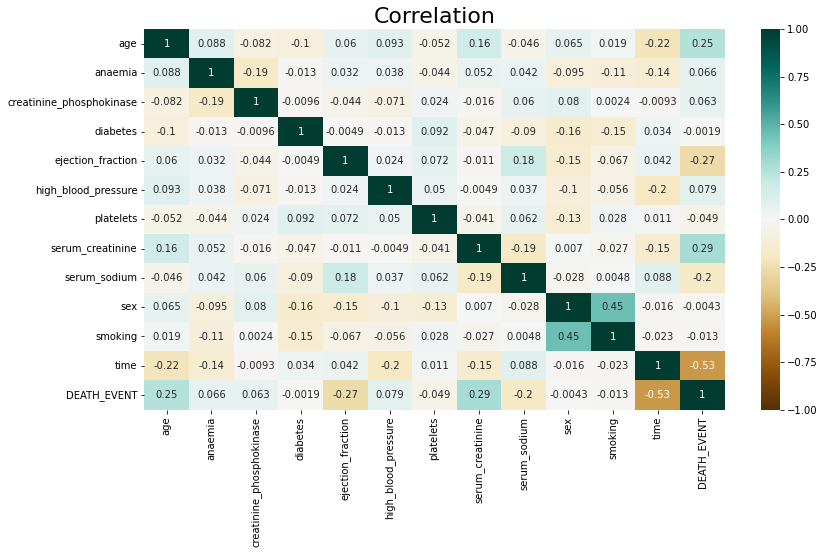

In [9]:
plt.figure(figsize=(13,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG', annot=True)
plt.title('Correlation', fontsize = 22)

plt.savefig('../Heart Failure Prediction/images/Correlation.png')
plt.show()

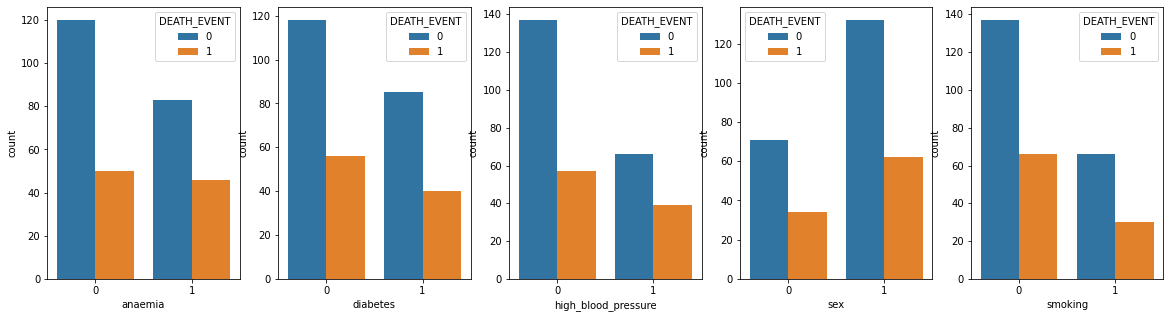

In [10]:
# categorical_variables_impact
plt. figure(figsize=(20,5))
for i,c in enumerate(categorical):
    plt.subplot (1,5,i+1)
    sns.countplot(data = df, x=c, hue='DEATH_EVENT')

plt.savefig('../Heart Failure Prediction/images/categorical_variables_impact.png')
plt.show()

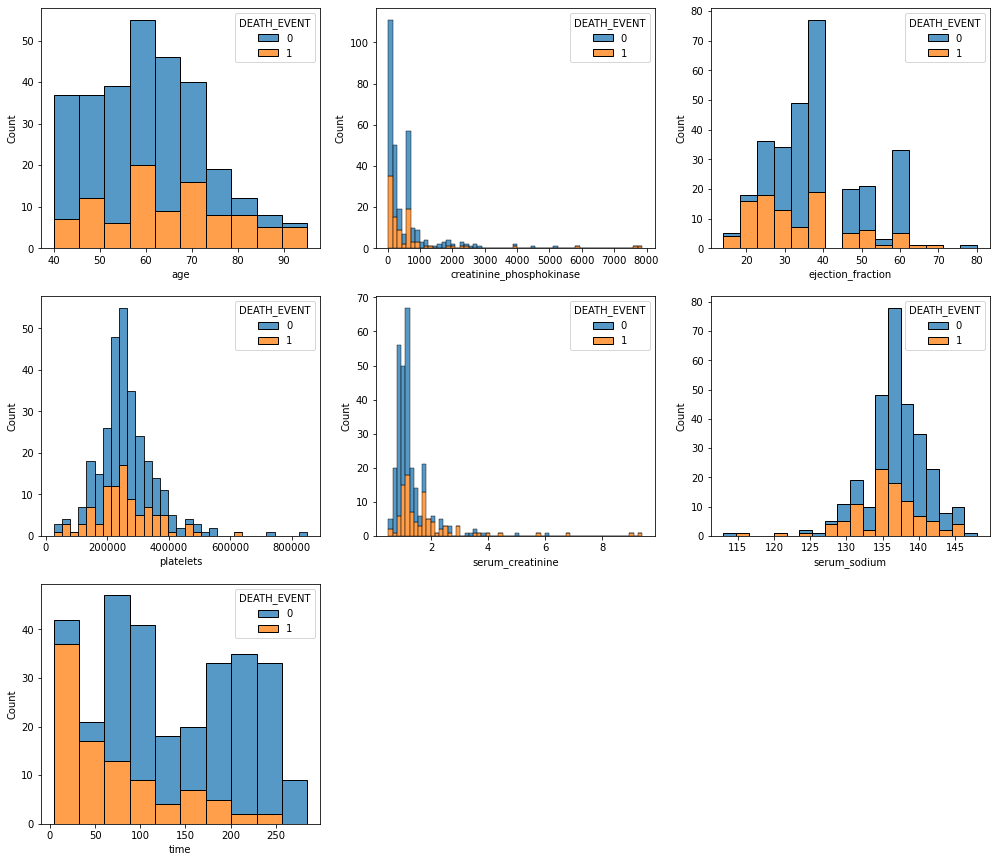

In [11]:
plt.figure(figsize=(17,15))
for j,co in enumerate(continuous):
    plt. subplot (3,3,j+1)
    sns.histplot(data = df, x=co, hue = 'DEATH_EVENT', multiple='stack')
plt.savefig('../Heart Failure Prediction/images/continuous_variables_impact.png')
plt.show()

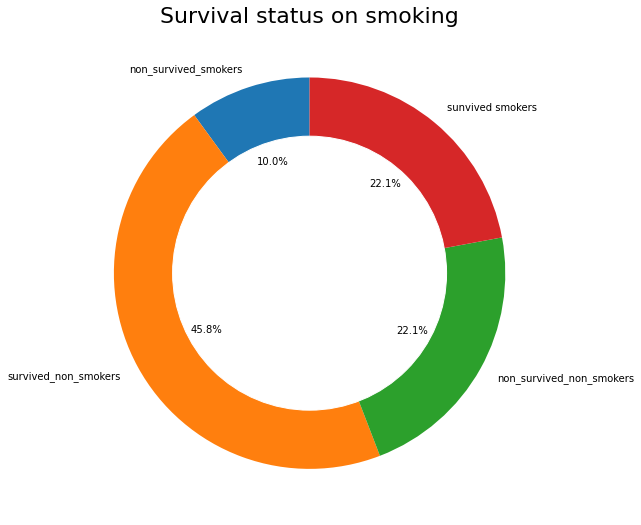

In [12]:
# Analyzing the survival status on smoking

smokers = df[df['smoking']==1]
non_smokers = df[df['smoking']==0]
 

non_survived_smokers = smokers[smokers['DEATH_EVENT']==1]
survived_non_smokers = non_smokers[non_smokers['DEATH_EVENT']==0]
non_survived_non_smokers = non_smokers[non_smokers['DEATH_EVENT']==1]
survived_smokers = smokers[smokers['DEATH_EVENT']==0]

smoking_data = [len(non_survived_smokers), len(survived_non_smokers) , len(non_survived_non_smokers),len(survived_smokers)]
smoking_labels = ['non_survived_smokers', 'survived_non_smokers', 'non_survived_non_smokers', 'sunvived smokers']
plt.figure(figsize=(9,9))
plt.pie(smoking_data, labels = smoking_labels, autopct='%.1f%%', startangle=90)
circle = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Survival status on smoking', fontsize=22)
plt.savefig('../Heart Failure Prediction/images/smoking.png')
plt.show()

# Modeling

In [13]:
x = df[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']]
y = df['DEATH_EVENT']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn_acc = round(accuracy_score(y_test, knn_pred)*100,2)
knn_roc = round(roc_auc_score(y_test, knn_pred)*100,2)

### LogisticRegression

In [16]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
lr_acc = round(accuracy_score(y_test, lr_pred)*100,2)
lr_roc = round(roc_auc_score(y_test, lr_pred)*100,2)

### DecisionTreeClassifier

In [17]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)
dt_acc = round(accuracy_score(y_test, dt_pred)*100,2)
dt_roc = round(roc_auc_score(y_test, dt_pred)*100,2)

### RandomForestClassifier

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = round(accuracy_score(y_test ,rf_pred)*100,2)
rf_roc = round(roc_auc_score(y_test ,rf_pred)*100,2)

### Support Vector Machine

In [19]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = round(accuracy_score(y_test, svc_pred)*100,2)
svc_roc = round(roc_auc_score(y_test, svc_pred)*100,2)

### GaussianNB

In [20]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
gnb_acc = round(accuracy_score(y_test, gnb_pred)*100,2)
gnb_roc = round(roc_auc_score(y_test, gnb_pred)*100,2)

### XGBoost

In [21]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = round(accuracy_score(y_test, xgb_pred)*100,2)
xgb_roc = round(roc_auc_score(y_test, xgb_pred)*100,2)

## Evaluate all models
- Accuracy
- roc_auc_score

In [22]:
Table = PrettyTable(["Algorithm", "Accuracy"])
Table.add_row(["KNN", knn_acc])
Table.add_row(["LogisticRegression", lr_acc])
Table.add_row(["DecisionTreeClassifier", dt_acc])
Table.add_row(["RandomForestClassifier", rf_acc])
Table.add_row(["GaussianNB", gnb_acc])
Table.add_row(["SVC", svc_acc])
Table.add_row(["xgboost", xgb_acc])
print(Table)

+------------------------+----------+
|       Algorithm        | Accuracy |
+------------------------+----------+
|          KNN           |  55.56   |
|   LogisticRegression   |   80.0   |
| DecisionTreeClassifier |  67.78   |
| RandomForestClassifier |  73.33   |
|       GaussianNB       |  76.67   |
|          SVC           |  58.89   |
|        xgboost         |  76.67   |
+------------------------+----------+


As we can see LogisticRegression has the best accuracy - 80%

In [23]:
Table = PrettyTable(["Algorithm", "roc_auc_score"])
Table.add_row(["KNN", knn_roc])
Table.add_row(["LogisticRegression", lr_roc])
Table.add_row(["DecisionTreeClassifier", dt_roc])
Table.add_row(["RandomForestClassifier", rf_roc])
Table.add_row(["GaussianNB", gnb_roc])
Table.add_row(["SVC", svc_roc])
Table.add_row(["xgboost", xgb_roc])
print(Table)

+------------------------+---------------+
|       Algorithm        | roc_auc_score |
+------------------------+---------------+
|          KNN           |      48.8     |
|   LogisticRegression   |      76.9     |
| DecisionTreeClassifier |     64.89     |
| RandomForestClassifier |     70.42     |
|       GaussianNB       |     72.85     |
|          SVC           |      50.0     |
|        xgboost         |     74.48     |
+------------------------+---------------+


LogisticRegression has the best AUC - ROC Curve - 76.9%

### Confusion matric of all models

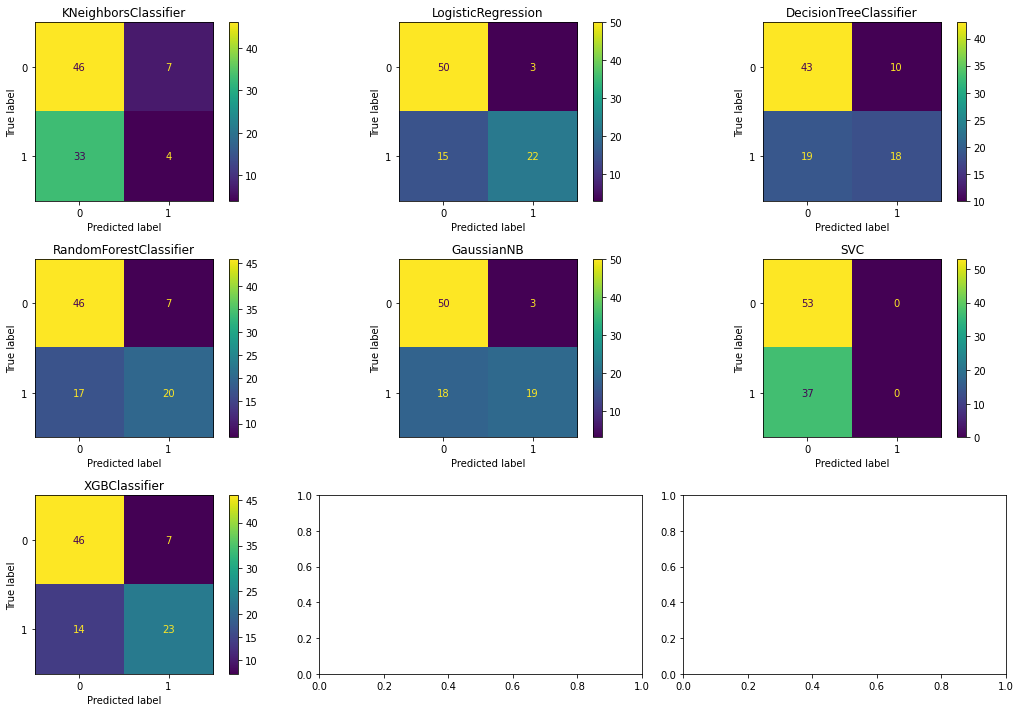

In [24]:
classifiers = [knn,lr,dt,rf,gnb,svc,xgb]
names = ('KNN','LogisticRegression','DecisionTreeClassifier','RandomForestClassifier', 'GaussianNB','SVC','xgboost')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for cl, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cl, 
                          X_test, 
                          y_test, 
                          ax=ax,
                          )
    ax.title.set_text(type(cl).__name__)
plt.tight_layout()  
plt.savefig('../Heart Failure Prediction/images/Confusion_matrix.png')
plt.show()

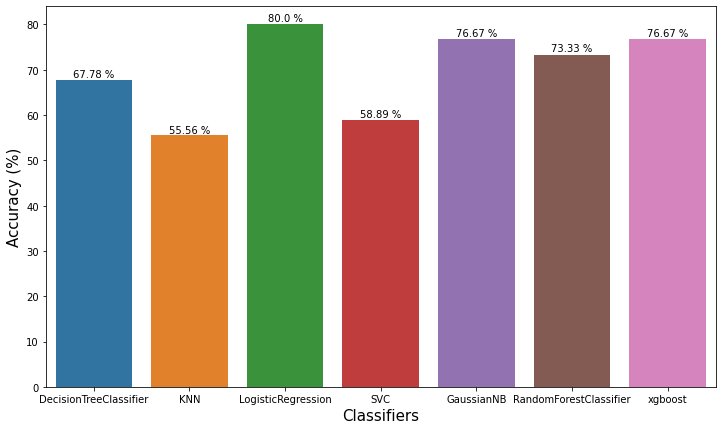

In [25]:
accuracy = [dt_acc,knn_acc,lr_acc,svc_acc,gnb_acc,rf_acc,xgb_acc]
model = ['DecisionTreeClassifier','KNN','LogisticRegression','SVC','GaussianNB','RandomForestClassifier' ,'xgboost']

plt.figure(figsize=(12,7))
ax = sns.barplot(x=model, y=accuracy)
plt.xlabel('Classifiers', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x()
    y = p.get_y()
    ax.annotate(f"{height} %", (x + width/2, y+ height*1.01), ha='center')
    
plt.savefig('../Heart Failure Prediction/images/Accuracy.png')
plt.show()